# Median-based Bandits with Unbounded Rewards

We consider the class of upper confidence bound bandit algorithms for sequential experiment design problems.
We propose a policy, $\textit{Median-based Upper Confidence Bound}$ (M-UCB), based on the empirical median, that is robust to skewed distributions and outliers. In each round ${t}$ ($t > K$), pick an arm with index

$$argmax_{i \in \mathcal{K}} \underbrace{\hat{m}_{i, T_i(t-1)}}_{\substack{\text{Empirical} \\ \text{Median}}} + \beta  \underbrace{\left(\sqrt{2v_{i,t} \varepsilon_t} + 2 \varepsilon_t \sqrt{\frac{v_{i,t}}{T_i(t-1)}}\right)}_{\text{Confidence Width}},$$


where $T_i(t-1)$ is the number of times arm $i$ has been played during first $t-1$ rounds, exploration factor $\varepsilon_t = \alpha \log t$ with $\alpha$ controlling the exploration rate, hazard factor $v_{i,t} = \frac{4 }{T_i(t-1) \hat{L}_{i,T_i(t-1)}^2}$, with $\hat{L}_{i, T_i(t-1)}$ as the lower bound estimation of hazard rate for reward distribution of arm $i$ at the round $t$.
    $\beta$ is a hyper-parameter balancing the empirical median and confidence width.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.UCB_discrete import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva

%matplotlib inline

## Simulations

We compare our policy M-UCB with four others: 1) U-UCB with empirical performance distribution measure as VaR, 2) $\epsilon$-greedy algorithm, which chooses a random arm with probability $\epsilon = 0.1$,  and otherwise the arm with highest empirical median, 3) robust UCB-median of mean, which allows heavy-tailed reward distributions. 4) adversarial bandit algorithm Exp3 which assumes the reward distributions are adversarial.
The performance of the algorithms are evaluated in terms of the expected sub-optimal draws. Note the plots are shown in log scale on the vertical axis.

Note that the robust UCB-median of means and Exp3 algorithms pick the arm with highest mean as the optimal arm, we thus evaluate these two algorithms with the optimal arm defined as the one with highest mean, as they will be disadvantaged if we choose the optimal arm with the maximum median.
Including these two algorithms allows us to benchmark against algorithms that allow
heavy-tailed distributions and adversarial problems respectively.
All other algorithms use median as summary statistics and evaluated with the optimal arm defined as the one with the highest median.

For simulations, we design reward distributions using the special case distributions of IHR (non-decreasing hazard rate distributions). The reward distribution for 3 arms are: A) $|\mathcal{N}(1.2, 4)|$ B) $|\mathcal{N}(3,1)|$  C) Exp(3.5). We simulate 50 independent experiments, where each experiment runs 10,000 rounds.

In [3]:
# setting

num_exper = 50
num_rounds = 5000
num_arms = 3
est_flag = True # estimate the lower bound of hazard rate L

# environment

environments = [
    {Mixture_AbsGau: [[3.5, 2, 0,1, 1], [0, 1.5, 0, 1, 1]], Exp: [1/4]}, # mu1, sigma1, mu2, sigma2, p
    
]

rewards_env, medians, means, mvs, samples = setup_env(num_arms, environments)

In [4]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C'
}

for key in medians.keys():
    print(key)
    medians[key] = list(np.around(np.array(medians[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    mvs[key] = list(np.around(np.array(mvs[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row(['Median'] + medians[key]+ [arm_name_dict[np.argmax(medians[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    print(t)
    print()

Mixture_AbsGau_[[3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[0.25]
+--------+------+------+------+----------+
|  Eva   |  A   |  B   |  C   | Best Arm |
+--------+------+------+------+----------+
| Median | 3.52 | 1.03 | 2.77 |    A     |
|  Mean  | 3.57 | 1.2  | 3.99 |    C     |
+--------+------+------+------+----------+



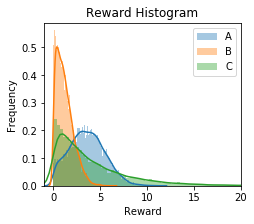

In [5]:
plot_hist(samples)

In [6]:
# run experiments

def run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [est_flag]):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(num_rounds)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                subname = policy_name + str(hyperpara)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname]= simulate(rewards_env[key],summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, None, p)
                
def run_exper_diff_para(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [est_flag]):
    for key in rewards_env.keys():
        for est_flag in est_flags:
            name = key + '_' + str(num_exper) + '_' + str(num_rounds)
            
            # setting different parameters to with and without outliers groups
            if 'Outlier' in name:
                hyperpara = hyperpara_list[-1]
            else:
                hyperpara = hyperpara_list[0]
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'

            subname = policy_name + str(hyperpara)
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname]= simulate(rewards_env[key], summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, None, p)

In [7]:
results = defaultdict(dict)


# M-UCB

hyperpara_list = [[1.05,0.35,1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, Q_UCB, medians)

#--------------------------------------------------------------------------------------------------------
# Benchmark algorithms

# U-UCB

hyperpara_list = [[4]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, U_UCB, medians)

# epsilon_greedy

hyperpara_list = [[0.3]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, epsilon_greedy, medians)

# Median_of_Means_UCB

hyperpara_list = [[10, 1, 1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, Median_of_Means_UCB, means)

# Exp3

hyperpara_list = [[0.5, 0, 30]]
run_exper_diff_para(rewards_env, hyperpara_list, num_exper, num_rounds, Exp3, means)


Mixture_AbsGau_[[3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[0.25]_50_5000Q_UCB-[1.05, 0.35, 1]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[0.25]_50_5000U_UCB-[4]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[0.25]_50_5000epsilon_greedy-[0.3]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[0.25]_50_5000Median_of_Means_UCB-[10, 1, 1]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[0.25]_50_5000Exp3-[0.5, 0, 30]


IntProgress(value=0, description='Running', max=50)

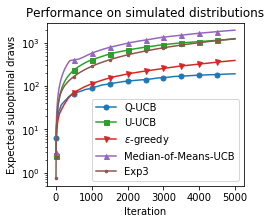

In [8]:
plot_eva(results, 'sd', paper_flag = True)

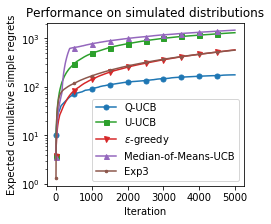

In [9]:
plot_eva(results, 'r', paper_flag = True)

The performance on the simulated distributions.
As we expected, our algorithm M-UCB outperforms the heavy-tailed method and the adversarial method. Since the light-tailed and stochastic assumption (e.g. sub-exponential, sub-Gaussian) allows us to design a policy with a faster convergence rate of empirical medians. 

Compared with algorithms which take median as summary statistics, our algorithm is still the best. As analyzed, U-UCB assumes bounded support of rewards and depends on a slow concentration convergence rate, which makes it have a higher number of sub-optimal draws. The idea of $\epsilon$-greedy is straight-forward, but it is usually hard to beat empirically.Tamkind et al. 2019 reported similar results, for CVaR regret minimisation, $\epsilon$-greedy is the best baseline algorithm empirically. 


## Save results

In [10]:
import pickle

with open('simulation.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)